# RNA Sequence to Gene Dependency Mapper
Train a model to map from Gene expression data to Gene Dependency data

Potential clinical use, given a cancer patients RNA seq data predict their Gene Dependencies. Choose appropriate drug.

One of the other uses of this notebook is to debug the deep architectures. We noticed that the validation error is often bellow the training error. This suggest a bug. see the presentation presentations/status-2020-03-13.pptx for an overview of how to debug.

<span style="color:red">TODO: debug using geneDependencyAutoEncoder notebook</span>

- [https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
- [https://machinelearningmastery.com/how-to-control-neural-network-model-capacity-with-nodes-and-layers/](https://machinelearningmastery.com/how-to-control-neural-network-model-capacity-with-nodes-and-layers/)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

## load data

In [2]:
rootDir = "data/autoEncoder/"
commonGeneDepPath = rootDir + "common_D2_Achilles_gene_dep_scores.csv"
commonRNASeqPath  = rootDir + "common_RNAseq_lRPKM_data.csv"

In [3]:
# cclbg == commonGenesByCellLine
cclbgGeneDepDF = pd.read_csv(commonGeneDepPath)
cclbgRNASeqDF = pd.read_csv(commonRNASeqPath)

### conver to numpy: 
Data is genes by cell lines. We need to transpose it to cell lines by genes

In [4]:
def transposeAndConvertToNumpy(df, verbose=False):
    '''
    if you dataset is genes by cell names use this function to convert it do cell names by genes
    
    input:
        df: a pandas data frame
        
        verbose: prints debug infomation
    '''
    if verbose:
        print("df")
        print(df.shape)
        print(df.iloc[0:4, 0:4])
        
    retDF = df.transpose()
    
    if verbose:
        print("\ntransposed df")
        print("shape:{}".format(retDF.shape))
        print("sample:\n{}".format(commonCellLineByGeneDepDF.iloc[0:4, 0:4]))

    retNp = retDF.iloc[1:, :].to_numpy().astype(np.double) # value have 17 decimal places
    
    if verbose:
        print("\nnumpy")
        print("return Np.shape:{}".format(retNp.shape))
        print("sample:\n{}".format(retNp[0:3, 0:3] ))

    return retNp
 

In [5]:
cclbgRNASeqNp = \
    transposeAndConvertToNumpy(cclbgRNASeqDF, verbose=False)
print("cclbgRNASeqNp.dtype:{}".format(cclbgRNASeqNp.dtype))

average_cclbgRNASeqNp = np.mean(cclbgRNASeqNp)
print("average_cclbgRNASeqNp:{}".format(average_cclbgRNASeqNp))

cclbgGeneDepNp = \
    transposeAndConvertToNumpy(cclbgGeneDepDF, verbose=False)
print("cclbgGeneDepNp.dtype:{}".format(cclbgGeneDepNp.dtype))

average_cclbgGeneDep = np.mean(cclbgGeneDepNp)
print("average_cclbgGeneDep:{}".format(average_cclbgGeneDep))

cclbgRNASeqNp.dtype:float64
average_cclbgRNASeqNp:-0.06471496262132301
cclbgGeneDepNp.dtype:float64
average_cclbgGeneDep:-0.06328828307250574


In [6]:
# do not hold on to memory accidentally
cclbgGeneDepDF = None
cclbgRNASeqDF = None

## split into test and train sets
<span style="color:red">TODO: AEDWIP: create train, validation, and test sets</span>

In [7]:
cclbgRNASeqTrainXNp, cclbgRNASeqTestXNp, \
    cclbgDepTrainYNp, cclbgGeneDepTestYNp = \
        train_test_split( cclbgRNASeqNp, cclbgGeneDepNp, \
                     test_size=0.1, random_state=42)

In [8]:
print("cclbgRNASeqTrainXNp.shape: {}".format(cclbgRNASeqTrainXNp.shape))
print("cclbgRNASeqTestXNp.shape:  {}".format(cclbgRNASeqTestXNp.shape))
print()
print("cclbgDepTrainYNp.shape:{}".format(cclbgDepTrainYNp.shape))
print("cclbgGeneDepTestYNp.shape: {}".format(cclbgGeneDepTestYNp.shape))

cclbgRNASeqTrainXNp.shape: (437, 10499)
cclbgRNASeqTestXNp.shape:  (49, 10499)

cclbgDepTrainYNp.shape:(437, 10499)
cclbgGeneDepTestYNp.shape: (49, 10499)


# Create Auto Encoder Model and Architecture

In [9]:
def buggyArchPart1():
    '''
    https://blog.keras.io/building-autoencoders-in-keras.html
    
    the autoencoder will make predictions,
    the decoder model will make predictions
    the encoder returns zero
    '''
    numExamples, numFeatures = cclbgRNASeqTrainXNp.shape
    print("numExamples:{} numFeatures:{}".format(numExamples, numFeatures))
    encodingDim = 20 #1000

    # create a trival autoencoder model
    inputCellLineLayer = Input(shape=(numFeatures,))
    encoderLayer       = Dense(encodingDim, activation='relu')(inputCellLineLayer)
    decoderLayer       = Dense(numFeatures, activation='relu')(encoderLayer)

    # input ->encode -> decode
    autoencoderModel = Model(inputs=inputCellLineLayer, outputs=decoderLayer) 

    # # create that just encodes
    # # input -> encode
    # this looks like a bug the encoderLayer is already connected to an input
    # encoderModel = Model(inputs=inputCellLineLayer, outputs=encoderLayer) 

    # # create model that decodes
    # # encodingDimInput -> decode numFeatures
    # encodedInputLayer = Input(shape=(encodingDim,))
    # # is this a bug? can we use the same layer connected to different inputs
    # decoderLayer = autoencoderModel.layers[-1] # fetch the layer

    # decoderModel = Model(inputs=encodedInputLayer, outputs=decoderLayer(encodedInputLayer))

    autoencoderModel.compile(loss='mean_squared_error', optimizer = Adam())
    
    return autoencoderModel

In [10]:
def buggyArchPart2():
    '''
    https://blog.keras.io/building-autoencoders-in-keras.html
    
    the autoencoder will make predictions,
    the decoder model will make predictions
    the encoder returns zero
    '''
    numExamples, numFeatures = cclbgRNASeqTrainXNp.shape
    print("numExamples:{} numFeatures:{}".format(numExamples, numFeatures))
    encodingDim = 20 #1000

    # create a trival autoencoder model
    inputCellLineLayer = Input(shape=(numFeatures,))
    encoderLayer       = Dense(encodingDim, activation='relu')(inputCellLineLayer)
    decoderLayer       = Dense(numFeatures, activation='relu')(encoderLayer)

    # input ->encode -> decode
    autoencoderModel = Model(inputs=inputCellLineLayer, outputs=decoderLayer) 

    # # create that just encodes
    # # input -> encode
    # this looks like a bug the encoderLayer is already connected to an input
    encoderModel = Model(inputs=inputCellLineLayer, outputs=encoderLayer) 

    # # create model that decodes
    # # encodingDimInput -> decode numFeatures
    encodedInputLayer = Input(shape=(encodingDim,))
    # # is this a bug? can we use the same layer connected to different inputs
    decoderLayer = autoencoderModel.layers[-1] # fetch the layer

    decoderModel = Model(inputs=encodedInputLayer, outputs=decoderLayer(encodedInputLayer))

    autoencoderModel.compile(loss='mean_squared_error', optimizer = Adam())
    
    return autoencoderModel, encoderModel, decoderModel

In [11]:
def trivalArch():
    
    numExamples, numFeatures = cclbgRNASeqTrainXNp.shape
    print("numExamples:{} numFeatures:{}".format(numExamples, numFeatures))
    encodingDim = 20

    autoencoderModel = Sequential()
    autoencoderModel.add( Dense(encodingDim, activation='relu', name="encoder", input_shape=(numFeatures,)) )
    autoencoderModel.add( Dense(numFeatures, activation='relu', name="decoder") )

    autoencoderModel.compile(loss='mean_squared_error', optimizer = Adam())
    return autoencoderModel

In [12]:
def multiLayerArch(metrics=['accuracy', 'mse']):
    '''
    https://www.tensorflow.org/api_docs/python/tf/keras/metrics

    '''
    numExamples, numFeatures = cclbgRNASeqTrainXNp.shape
    # our low rank matrix factorization model worked best with 19 features
    encodingDim = 64 #128 # 64 #50 # 20 #100 #20
    print("numExamples:{} numFeatures:{} encodingDim:{}".format(numExamples, numFeatures, encodingDim))

    autoencoderModel = Sequential()

    # adding an input layer this way instead of using input_shape argument
    # of first layer makes it easier to change the arch
    autoencoderModel.add(Input(shape=(numFeatures,), name="input"))

    autoencoderModel.add(Dense(1024, activation='relu', name="e1024"))
    autoencoderModel.add(Dense( 512, activation='relu', name="e512"))
    autoencoderModel.add(Dense( 256, activation='relu', name="e256"))
    autoencoderModel.add(Dense( 128, activation='relu', name="e128"))

    #autoencoderModel.add(Dense(encodingDim,    activation='linear', name="bottleneck"))
    autoencoderModel.add(Dense(encodingDim,    activation='relu', name="bottleneck"))

    # decoder part of model
    autoencoderModel.add(Dense( 128, activation='relu', name="d128"))
    autoencoderModel.add(Dense( 256, activation='relu', name="d256"))
    autoencoderModel.add(Dense( 512, activation='relu', name="d512"))
    autoencoderModel.add(Dense(1024, activation='relu', name="d1024"))

    # do not use sigmoid all predictions will be zero. makes sence 
    #autoencoderModel.add(Dense(numFeatures,    activation='sigmoid', name="dOut"))
    autoencoderModel.add(Dense(numFeatures,    activation='relu', name="dOut"))

    # set up our optimizer
    # https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
    autoencoderModel.compile(loss='mean_squared_error', optimizer=Adam(),  metrics=metrics)
    # autoencoderModel.compile(loss='mean_absolute_error', optimizer=Adam(),  metrics=metrics)
    # autoencoderModel.compile(loss='mean_squared_logarithmic_error', optimizer=Adam(),  metrics=metrics)
    # ? no RMSE? autoencoderModel.compile(loss='root_mean_squared_error', optimizer=Adam(),  metrics=metrics)
    
    return autoencoderModel


In [13]:
meaningOfLife = 42
np.random.seed(meaningOfLife)
tf.random.set_seed(meaningOfLife)

# trivalArch() produces crappy predictions
#autoencoderModel = trivalArch(); encoderModel = None; decoderModel = None

# buggyArchPart1 produces crappy predictions
#autoencoderModel = buggyArchPart1(); encoderModel = None; decoderModel = None

# buggyArchPart2
# encoderModel does not produce predictions
# suggest the buggyArchPart1 encoding layer might not be working
# autoencoderModel, encoderModel, decoderModel = buggyArchPart2()

autoencoderModel = multiLayerArch(metrics=['accuracy', 'mse']); encoderModel = None; decoderModel = None

# TODO: AEDWIP: add shuffle. I do not think it will make much difference
valData = (cclbgRNASeqTestXNp,  cclbgGeneDepTestYNp)
%time history = autoencoderModel.fit(\
                                    cclbgRNASeqTrainXNp, \
                                    cclbgDepTrainYNp, \
                                    batch_size=1024, \
                                    epochs=15, \
                                    verbose=1, \
                                    validation_data=valData )

numExamples:437 numFeatures:10499 encodingDim:64
Train on 437 samples, validate on 49 samples
Epoch 1/15
437/437 [==============================] - 2s 4ms/sample - loss: 0.0514 - accuracy: 0.0000e+00 - mse: 0.0514 - val_loss: 0.0523 - val_accuracy: 0.0000e+00 - val_mse: 0.0523
Epoch 2/15
437/437 [==============================] - 0s 704us/sample - loss: 0.0527 - accuracy: 0.0000e+00 - mse: 0.0527 - val_loss: 0.0498 - val_accuracy: 0.0204 - val_mse: 0.0498
Epoch 3/15
437/437 [==============================] - 0s 668us/sample - loss: 0.0502 - accuracy: 0.0000e+00 - mse: 0.0502 - val_loss: 0.0491 - val_accuracy: 0.0408 - val_mse: 0.0491
Epoch 4/15
437/437 [==============================] - 0s 666us/sample - loss: 0.0496 - accuracy: 0.0183 - mse: 0.0496 - val_loss: 0.0478 - val_accuracy: 0.4694 - val_mse: 0.0478
Epoch 5/15
437/437 [==============================] - 0s 664us/sample - loss: 0.0483 - accuracy: 0.4439 - mse: 0.0483 - val_loss: 0.0477 - val_accuracy: 0.0204 - val_mse: 0.0477
Ep

In [14]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])


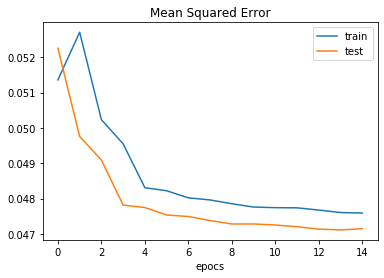

In [15]:
plt.title('Mean Squared Error')
plt.xlabel('epocs')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

In [16]:
for layer in autoencoderModel.layers:
    print(layer.name)

e1024
e512
e256
e128
bottleneck
d128
d256
d512
d1024
dOut


In [17]:
if encoderModel:
    for layer in encoderModel.layers:
        print(layer.name)

In [18]:
if decoderModel:
    for layer in decoderModel.layers:
        print(layer.name)

In [19]:
def debug(name, npArray, n=3):
    print("{}.shape:{}".format(name, npArray.shape))
    print("{}[0:{}, 0:{}]\n{}".format(name, n, n, npArray[0:n, 0:n]))
    
predictedTrain = autoencoderModel.predict(cclbgRNASeqTrainXNp)
print()
debug("predictedTrain", predictedTrain, 10)

if encoderModel:
    encodedData = encoderModel.predict(cclbgRNASeqTrainXNp)
    print()
    debug("encodedData", encodedData, 10)

if decoderModel:
    decodedData = decoderModel.predict(encodedData)
    print()
    debug("decodedData", decodedData, 10)


# decodedData should equal cclbgDepTrainYNp
print()
debug("cclbgDepTrainYNp", cclbgDepTrainYNp, 3)


predictedTrain.shape:(437, 10499)
predictedTrain[0:10, 0:10]
[[-0.         -0.         -0.          0.16758056  0.06720156 -0.
  -0.         -0.          0.03622453  0.09220303]
 [-0.         -0.         -0.          0.18149713  0.06572786 -0.
  -0.         -0.          0.04046548  0.09789281]
 [-0.         -0.         -0.          0.17656091  0.06346402 -0.
  -0.         -0.          0.03660684  0.09493518]
 [-0.         -0.         -0.          0.16534986  0.0617654  -0.
  -0.         -0.          0.03552351  0.09053127]
 [-0.         -0.         -0.          0.16200168  0.06390137 -0.
  -0.         -0.          0.03404035  0.08865543]
 [-0.         -0.         -0.          0.17396872  0.06381837 -0.
  -0.         -0.          0.03846032  0.0937293 ]
 [-0.         -0.         -0.          0.16453135  0.06308136 -0.
  -0.         -0.          0.03506794  0.08807198]
 [-0.         -0.         -0.          0.17337775  0.06797101 -0.
  -0.         -0.          0.03651042  0.09797969]
 [

In [27]:
loss = tf.keras.losses.mean_squared_error(cclbgDepTrainYNp, predictedTrain)
#loss = tf.keras.losses.mean_squared_error(cclbgRNASeqTrainXNp, predictedTrain)
viewN = 3
print("cclbgDepTrainYNp[0:{}]:\n{}".format(viewN, cclbgDepTrainYNp[0:viewN]))
print("\npredictedTrain[0:{}]       :\n{}".format(viewN, predictedTrain[0:viewN]))
print("\nloss[0:{}]            :\n{}".format(viewN, loss[0:viewN]))

print("\ntotalLoss: {}".format(np.sum(loss)))

r2 = r2_score(y_true=cclbgDepTrainYNp, y_pred=predictedTrain) #  -5.7502487180452135
aedwip = r2_score(y_true=predictedTrain, y_pred=cclbgDepTrainYNp)
print("\nwe have a nonlinear regression model, R2 stat may not be an appropriate stat to use\ntraining set R squared: {}".format(r2))# -475456.6033642749

print("\naverage_cclbgGeneDep:{}".format(average_cclbgGeneDep))

cclbgDepTrainYNp[0:3]:
[[-0.1104474   0.02873079 -0.04848716 ...  0.10376965 -0.03699218
  -0.0097903 ]
 [-0.15634466  0.20082609 -0.1109807  ...  0.08425841 -0.19582009
   0.0548986 ]
 [-0.15079345  0.08213084 -0.03073966 ...  0.01452408 -0.12964246
   0.04303337]]

predictedTrain[0:3]       :
[[-0.         -0.         -0.         ...  0.14163406 -0.
   0.05848427]
 [-0.         -0.         -0.         ...  0.15219475 -0.
   0.06390738]
 [-0.         -0.         -0.         ...  0.14726032 -0.
   0.06157347]]

loss[0:3]            :
[0.04651911 0.04262278 0.04498693]

totalLoss: 20.807048797607422

we have a nonlinear regression model, R2 stat may not be an appropriate stat to use
training set R squared: -5.7502487180452135

average_cclbgGeneDep:-0.06328828307250574


# Arch tunning
keep track of different results

### exp1 multiLayerArch()
```
encodingDim = 100
totalLoss:20.911518096923828

e256
e128
bottleneck
d128
d256
dOut
```

### exp2 multiLayerArch()
```
encodingDim = 50
totalLoss:20.849037170410156
```

### exp3 multiLayerArch()
```
encodingDim = 20
totalLoss:20.87580108642578
```

### exp 4 multiLayerArch()
```
encodingDim = 50
totalLoss:20.741943359375

e512
e256
e128
bottleneck
d128
d256
d512
dOut
```

### exp 5 multiLayerArch()
```
encodingDim:64
totalLoss:20.758359909057617
e1024
e512
e256
e128
bottleneck
d128
d256
d512
d1024
dOut
```